# 1. Creating meshes

`Quagmire` can model surface processess on a structured rectangular grid or unstructured triangulated points. These use-cases are bundled into two objects:

- `PixMesh`: meshing on a rectangular grid
- `TriMesh`: meshing on unstructured triangular points
- `sTriMesh`: meshing on unstructured triangular points on the sphere

All meshes are generated and handed to Quagmire using a `DM` object where the selection of `PixMesh`, `TriMesh`, or `sTriMesh` is identified automatically by `QuagMesh`. The following data structures are built:

- Delaunay triangulation
- node neighbour array
- pointwise area and weights
- boundary information
- Rbf smoothing kernel

In this notebook we setup different `DM` objects using meshes found in the `quagmire.tools.meshtools` path and hand them to `QuagMesh`.

In [40]:
from quagmire.tools import meshtools
from quagmire import QuagMesh
import numpy as np

## Structured grids

In [41]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

resX = 75
resY = 75

DM = meshtools.create_DMDA(minX, maxX, minY, maxY, resX, resY)

print(type(DM))

<class 'petsc4py.PETSc.DMDA'>


This is a native PETSc data management object for structured grids (`DMDA`). This object has a number of 
useful methods and attached data which can be listed with

```python
help(DM)
```

We hand this to `QuagMesh` to generate the necessary data structures for gradient operations, smoothing, neighbour allocation, etc.

In [42]:
mesh = QuagMesh(DM)

Underlying Mesh type: PixMesh
0 - cKDTree 0.0034633329998996487s
0 - Find boundaries 0.002306667000084417s
0 - Construct neighbour cloud arrays 0.029511375000083717s, (0.0155398750000586s + 0.013944875000106549s)
0 - Construct rbf weights 0.007861209000111558s


We attach data to a mesh solely through mesh variables (see [Example notebook](Ex1a-QuagmireMeshVariables.md) for details)

``` python
    mesh_variable = mesh.add_variable(name="data1")
    mesh_variable.data = np.sin(mesh.coords[:,0] * np.pi)
    mesh_variable.sync()
```

The `sync` operation ensures data is coherent across processors - 
it is harmless and relatively inexpensive so is safe to use even 
in cases like this where there is no way for information to be out
of sync between domains.

In [43]:
mesh_variable = mesh.add_variable(name="data1")
mesh_variable.data = np.sin(mesh.coords[:,0] * np.pi)
mesh_variable.sync()

mesh_variable2 = mesh.add_variable(name="data2")
mesh_variable2.data = np.sin(mesh.coords[:,0] * 0.2 * np.pi) * np.cos(mesh.coords[:,1] * 0.2 * np.pi) 
mesh_variable2.sync()

In [44]:
XY = mesh.coords
XYZ = np.vstack((XY[:,0],XY[:,1], mesh_variable2.data)).T


## Visualisation 

Visualisation of meshes is explained in more detail in [Ex1.1-Visualising-Meshes](./Ex1.1-Visualising-Meshes.ipynb) so we will just look at the results of the visualisation for the moment.

In [45]:
import numpy as np
import k3d

plot = k3d.plot(camera_auto_fit=True, grid_visible=False)

plot += k3d.points(XYZ, point_size=0.05)

plot += k3d.surface(mesh_variable2.data.reshape((mesh.nx,mesh.ny)), 
                   xmin=mesh.minX, xmax=mesh.maxX, ymin=mesh.minY, ymax=mesh.maxY,
                   color=0x995500
                   )
plot.display()

/Users/lmoresi/mambaforge/envs/underworld/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [46]:
# import lavavu

# lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[500,500], near=-10.0)

# lvmesh = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=True)
# lvmesh.vertices(mesh.coords)
# lvmesh.values( mesh_variable.data, "sinx")
# lvmesh.colourmap("#FF0000, #555555 #0000FF", range=[-1.0,1.0])

# # The mesh can be given a height mapping like this

# vertices = np.zeros((mesh.coords.shape[0],3))
# vertices[:,0:2] = mesh.coords
# vertices[:,2]   = mesh_variable2.data * 0.5

# lvmesh2 = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=False)
# lvmesh2.vertices(vertices)
# lvmesh2.values(mesh_variable2.data,"sinxcosy")
# lvmesh2.colourmap("#FF0000, #FFFFFF:0.5 #0000FF", range=[-1.0,1.0])


# lv.control.Panel()
# lv.control.ObjectList()
# lv.control.show()

## Unstructured meshes

This is handled by PETSc's `DMPlex` object, which requires the connectivity of a set of points. The connectivity between points can be triangulated using the built-in mesh creation tools:

```python
x, y, simplices = square_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
x, y, simplices = elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
```

and handed to `DMPlex` using:

```python
DM = meshtools.create_DMPlex(x, y, simplices, boundary_vertices=None, refinement_levels=0)
```

---

Alternatively, an arbitrary set of points (without duplicates) can be triangulated and processed as a `DMPlex` object using:

```python
meshtools.create_DMPlex_from_points(x, y, bmask=None, refinement_levels=0)
```

If no boundary information is provided, the boundary is assumed to be the convex hull of points.


#### Parallel notes

The triangulation from the root processor is distributed to other processors using the `DM` object, including boundary points and boundary edges. The mesh can be refined efficiently in parallel using the `refine_dm` method. The order of this operation is important:

1. Triangulate points
2. Mark boundary edges
3. Distribute `DMPlex` to other processors
4. Refine the mesh

## Elliptical mesh

In [47]:
spacingX = 0.1
spacingY = 0.1

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

mesh = QuagMesh(DM)

mesh_equant = mesh.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh.area))

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.004698625000173706s
0 - Calculate node weights and area 0.0006435829998281406s
0 - Find boundaries 0.0009458749998429994s
0 - cKDTree 0.0008878749999894353s
0 - Construct neighbour cloud arrays 0.010321582999949896s, (0.007003082999972321s + 0.0032964580000225396s)
0 - Construct rbf weights 0.0013669160000517877s


In [48]:
import k3d
plot = k3d.plot(camera_auto_fit=True,   grid_visible=False)

mesh0 = mesh
indices = mesh0.tri.simplices.astype(np.uint32)
points  = np.column_stack((mesh0.coords, mesh0.coords[:,0]*0.0)).astype(np.float32)
plt_mesh = k3d.mesh(points, indices, wireframe=True, color=0xFF8000)
plot += plt_mesh
plot.display()



Output()

## Mesh improvement

Applies Lloyd's algorithm of iterated voronoi construction to improve the mesh point locations. This distributes the points to a more uniform spacing with more equant triangles. It can be very slow for anything but a small mesh. [Refining](#Mesh-refinement) the mesh a few times will produce a large, well-spaced mesh.

In [49]:
bmask = mesh.bmask.copy()

x1, y1 = meshtools.lloyd_mesh_improvement(x, y, bmask, iterations=3)
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask)

mesh1 = QuagMesh(DM)

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.003389666999964902s
0 - Calculate node weights and area 0.00048416699996778334s
0 - Find boundaries 0.00044929199998478s
0 - cKDTree 0.00035741600004257634s
0 - Construct neighbour cloud arrays 0.010160874999883163s, (0.006841458000053535s + 0.0032979590000650205s)
0 - Construct rbf weights 0.0010214999999789143s


In [50]:
mesh1_equant = mesh1.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh1.area))

In [51]:
import k3d
plot = k3d.plot(camera_auto_fit=True,   grid_visible=False)

mesh0 = mesh1
indices = mesh0.tri.simplices.astype(np.uint32)
points  = np.column_stack((mesh0.coords, mesh0.coords[:,0]*0.0)).astype(np.float32)
plt_mesh = k3d.mesh(points, indices, wireframe=True, color=0xFF8000)
                                       
plot += plt_mesh

mesh0 = mesh
points  = np.column_stack((mesh0.coords, mesh0.coords[:,0]*0.0)).astype(np.float32)
plot += k3d.points(points, point_size=0.05)

plot.display()


Output()

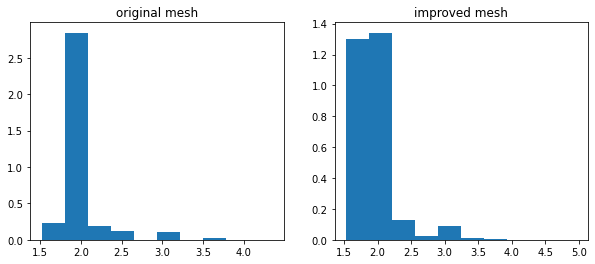

In [52]:
# Comparison of point-wise area for original and improved mesh


import matplotlib.pyplot as plt
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.hist(mesh_equant, density=True)
ax2.hist(mesh1_equant, density=True)

ax1.set_title('original mesh')
ax2.set_title('improved mesh')

plt.show()

## Mesh refinement

Triangulating a large set of points on a single processor then distributing the mesh across multiple processors can be very slow. A more time effective workflow is to create an initial `DM` with a small number of points, then refine the mesh in parallel. This is achieved by adding the midpoint of each line segment to the mesh and can be iteratively refined until the desired level of detail is reached.

```python
refine_DM(dm, refinement_levels=1)
```

In [53]:
spacingX = 0.5
spacingY = 0.5

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

DM_r1 = meshtools.refine_DM(DM, refinement_levels=1)
DM_r2 = meshtools.refine_DM(DM, refinement_levels=2)


# verbose=False turns off the timings

mesh0 = QuagMesh(DM, verbose=False)
mesh1 = QuagMesh(DM_r1, verbose=False)
mesh2 = QuagMesh(DM_r2, verbose=False)


v = DM_r1.getCoordinates()
v.array.shape

(686,)

In [61]:
# def plot_points(lv, points, label, **kwargs):    
#     lv_pts = lv.points(label, **kwargs)
#     lv_pts.vertices(points)
#     return lv_pts

# def plot_triangles(lv, points, triangles, label, **kwargs):
#     lv_tri = lv.triangles(label, **kwargs)
#     lv_tri.vertices(points)
#     lv_tri.indices(triangles)
#     return lv_tri


# lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

# bnodes0 = plot_points(lv, mesh0.coords[~mesh0.bmask], "boundary_points_r0", colour="red", pointsize=10)
# bnodes1 = plot_points(lv, mesh1.coords[~mesh1.bmask], "boundary_points_r1", colour="blue", pointsize=10)
# bnodes2 = plot_points(lv, mesh2.coords[~mesh2.bmask], "boundary_points_r2", colour="#336611", pointsize=10)

# tri0 = plot_triangles(lv, mesh0.coords, mesh0.tri.simplices, "mesh_r0", wireframe=True, linewidth=1.5, colour="red")
# tri1 = plot_triangles(lv, mesh1.coords, mesh1.tri.simplices, "mesh_r1", wireframe=True, linewidth=1.0, colour="blue")
# tri2 = plot_triangles(lv, mesh2.coords, mesh2.tri.simplices, "mesh_r2", wireframe=True, linewidth=1.0, colour="#336611")

# lv.control.Panel()
# lv.control.ObjectList()
# lv.control.show()

# lv.show()


import k3d
plot = k3d.plot(camera_auto_fit=True,   grid_visible=False)

mesh = mesh2
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack((mesh.coords, mesh.coords[:,0]*0.0)).astype(np.float32)
plot += k3d.mesh(points, indices, wireframe=True, color=0x0000FF)
plot += k3d.points(points, point_size=0.05, color=0x0000FF)

mesh = mesh1
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack((mesh.coords, mesh.coords[:,0]*0.0)).astype(np.float32)
plot += k3d.mesh(points, indices, wireframe=True, color=0x00FF00)
plot += k3d.points(points, point_size=0.075, color=0x00FF00)

mesh = mesh0
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack((mesh.coords, mesh.coords[:,0]*0.0)).astype(np.float32)
plot += k3d.mesh(points, indices, wireframe=True, color=0xFF0000)
plot += k3d.points(points, point_size=0.1, color=0xFF0000)


plot.display()



Output()

The DM contains two labels -- "coarse" and "boundary" -- which contain the vertices of boundary nodes and the unrefined mesh, respectively. They can be retrieved using:

```python
mesh.get_label("boundary")
mesh.get_label("coarse")
```

or a new label can be set using:

```python
mesh.set_label("my_label", indices)
```

In [62]:
coarse_pts0 = mesh0.get_label("coarse")
coarse_pts1 = mesh1.get_label("coarse")
coarse_pts2 = mesh2.get_label("coarse")

print("{} boundary points".format( len(mesh0.get_label("boundary")) ))
print("{} boundary points".format( len(mesh1.get_label("boundary")) ))
print("{} boundary points".format( len(mesh2.get_label("boundary")) ))


# the coarse point vertices should be identical
# refinement adds new points to the end of the x,y arrays

set(coarse_pts0) == set(coarse_pts1) == set(coarse_pts2)

18 boundary points
36 boundary points
72 boundary points


True

## Spherical meshes

This unstructed mesh uses PETSc's `DMPlex` object, and uses [stripy](https://github.com/underworldcode/stripy) to triangulate on the unit sphere. Multiple meshes may be created, including:

```python
DM = meshtools.create_spherical_DMPlex(lons, lats, simplices, boundary_vertices=None)
DM = meshtools.create_DMPlex_from_spherical_points(lons, lats, simplices, bmask=None, refinement_levels=0)
```

If no boundary information is provided, the boundary is calculated from any line segments that do not share a triangle with another.a

In [63]:
import stripy

lons, lats, bmask = meshtools.generate_elliptical_points(-40, 40, -80, 80, 0.1, 0.1, 1500, 200)

icomesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=5, include_face_points=True)

lons = np.degrees(icomesh.lons)
lats = np.degrees(icomesh.lats)
bmask = None

DM = meshtools.create_DMPlex_from_spherical_points(lons, lats, bmask, refinement_levels=0)
mesh0 = QuagMesh(DM)


Origin =  0.0 0.0 Radius =  40.0 Aspect =  2.0
Underlying Mesh type: sTriMesh
0 - Delaunay triangulation 0.049711750000142274s
0 - Calculate node weights and area 0.008660291000069265s
0 - Find boundaries 0.003692999999884705s
0 - cKDTree 0.004933917000016663s
0 - Construct neighbour cloud arrays 0.18275120899988906s, (0.14103324999996403s + 0.04168125000001055s)
0 - Construct rbf weights 0.014639875000057145s


In [72]:
b = open("GreyEarth.tif", "rb").read()

131327272

In [73]:
U = 0.5 + mesh0.tri.lons_map_to_wrapped(mesh0.tri.lons) / (2.0*np.pi) 
V = 0.5 - mesh0.tri.lats / np.pi

In [83]:
import k3d
plot = k3d.plot(camera_auto_fit=False)

indices = mesh0.tri.simplices.astype(np.uint32)
points  = np.column_stack(mesh0.tri.points.T).astype(np.float32)
uv      = np.column_stack((U,V)).astype(np.float32)

plot   += k3d.mesh(points, indices, wireframe=False, color=0xFFFFFF,
                    texture=b, texture_file_format="." , uvs=uv, 
                    opacity=1.0  )

plot   += k3d.points(points*0.999, point_size=0.005, color=0xFF0000)



plot.display()

Output()

## Save mesh to file

A mesh can be saved and imported later. The `QuagMesh` object has the `save_mesh_to_hdf5` method for this, as does `meshtools`.

**Note:** Requires PETSc 3.8 or higher

In [84]:
filename = "Ex1-refined_mesh.h5"

# save from QuagMesh object:
# mesh2.save_mesh_to_hdf5(filename)

# save from meshtools:
meshtools.save_DM_to_hdf5(DM_r2, filename)

# load DM from file
DM_r2 = meshtools.create_DMPlex_from_hdf5(filename)

mesh2 = QuagMesh(DM_r2)

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.008562083000015264s
0 - Calculate node weights and area 0.004568833000121231s
0 - Find boundaries 0.00612879200025418s
0 - cKDTree 0.005486542000198824s
0 - Construct neighbour cloud arrays 0.006377499999871361s, (0.003897624999808613s + 0.0024479170001541206s)
0 - Construct rbf weights 0.0014061249999031133s


In [85]:
print(mesh2.npoints)
print(mesh2.area)

1333
[0.1003038  0.07775106 0.07775106 ... 0.05819681 0.06067121 0.06067121]


The next example is [Ex2-Topography-Meshes](./Ex2-Topography-Meshes.md)